# User agent rank correlation

## Load data from Gaffer

In [1]:
import requests
import json
import sys
import gaffer
import threatgraph
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Number of 'user agents'
n = 10000

In [3]:
g = threatgraph.Gaffer()
g.use_cert()

In [4]:
op = gaffer.OperationChain([
    gaffer.GetAllElements(entities=[
        gaffer.ViewGroup("device", exclude=["count", "time"])
    ], edges=None),
    gaffer.GetWalks(
        operations=[
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("hasip", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ]), 
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("useragent")
                ], entities=None, include="OUTGOING")
            ])
        ],
        limit=10000000)
])

query = op.encode()
res = g.execute_chunked(op)

useragents = {}
timestamps = {}
counts = {}

all_useragents = set()
all_devices = set()

for v in res:

    try:
        ent = json.loads(v)

    except Exception:
        continue

    dev = list(ent["entities"][0].keys())[0]
    ua = list(ent["entities"][2].keys())[0]
    
    # Truncate user-agent string
    ua = ua[:30]
    k = (dev, ua)

    if not k in counts:
        counts[k] = 0
        timestamps[k] = set()
        
    if not dev in useragents:
        useragents[dev] = set()

    ts = ent["edges"][1][0]["properties"]["time"]["uk.gov.gchq.gaffer.time.RBMBackedTimestampSet"]["timestamps"]
    cnt = ent["edges"][1][0]["properties"]["count"]

    counts[k] += cnt
    timestamps[k].update(ts)
    useragents[dev].add(ua)
    all_useragents.add(ua)
    all_devices.add(dev)

In [5]:
all_devices = list(all_devices)
all_useragents = list(all_useragents)

## Construct user agent to device matrix

In [6]:
def get_counts(ua, dev):
    if ua in useragents[dev]: return counts[(dev, ua)]
    return 0

datas = [ [ get_counts(ua, dev) for dev in all_devices ] for ua in all_useragents]
df = pd.DataFrame(datas, index=all_useragents, columns=all_devices)
df["score"] = df.sum(axis=1)
df

,mark-mac,turing-minimacbook,LAPTOP-1I501C4U,ludicrous-mac,raymond-mac,serotinal-mac,abroad-android,essential-mac,dramatic-mac,turing-macbook,...,rarb-mac,minesweepers-mac,tirasse-mac,elysium-mac,essential-chrome,misskitty-mac,essential-cb,dgmac,simon-macpro,score
Python-urllib/3.5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
Mozilla/5.0 (Linux; Android 6.,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3727
Python-urllib/3.6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
"server-bag [Mac OS X,10.13.5,1",0,9,0,3,0,0,0,0,7,9,...,2,0,0,76,0,0,0,0,23,197
Spotlight/1075.40 CFNetwork/81,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,3
Spotify/106900336 (9; 0; 2),1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
LookupViewService/221 CFNetwor,0,0,0,0,0,4,0,0,0,0,...,0,3,0,0,0,2,0,0,0,9
Mac OS X/10.13.4 (17E202),10,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,25
(null)/(null) (Macintosh; OS X,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,2
GoogleSoftwareUpdate/1.2.10.10,0,2,0,0,2,0,0,0,5,0,...,3,5,0,6,0,0,0,0,2,35


## Get list of highest accessed user agents by all devices

In [7]:
top_uas = df.sort_values(by="score", ascending=False).index.values[:n]
top_uas

array(['Mozilla/5.0 (Macintosh; Intel ', 'Roblox/Darwin',
       'Mozilla/5.0 (X11; CrOS x86_64 ', 'Microsoft-Delivery-Optimizatio',
       'Mozilla/5.0 EA Download Manage', 'ProtoHttp 1.3/DS 15.1.2.3.0 (A',
       'python-requests/2.13.0', 'Mozilla/5.0 (X11; Ubuntu; Linu',
       'trustd (unknown version) CFNet', 'Mozilla/5.0 (Linux; Android 6.',
       'Dalvik/2.1.0 (Linux; U; Androi', 'Mozilla/5.0 (Windows NT 10.0; ',
       'Microsoft-WNS/10.0', 'Debian APT-HTTP/1.3 (1.2.26)',
       'MICROSOFT_DEVICE_METADATA_RETR', 'ClamAV/0.100.0 (OS: darwin17.5',
       'Microsoft-CryptoAPI/10.0', 'Spotify/8.4.61 Android/27 (Pix',
       'Mozilla/5.0 (Windows NT 6.1) A', 'Windows-Update-Agent/10.0.1001',
       'Safari/13605.2.8 CFNetwork/901', 'Microsoft BITS/7.8',
       'server-bag [Mac OS X,10.13.5,1', 'dnf/2.7.5',
       'Mozilla/5.0 (Linux; Android 8.', 'Software%20Update (unknown ver',
       'MacAppStore/2.4 (Macintosh; OS', 'Mac OS X/10.12.6 (16G1408)',
       'server-bag [Mac OS X,10.

## Spearman's Rho

In [8]:
# Calculate Rho on 2 lists
def spearman(a, b):
    
    n = max(len(a), len(b))
    bmap = {b[i]: i for i in range(0, len(b)) }

    tot = 0
    for i in range(0, len(a)):
        if a[i] in bmap:
            val = bmap[a[i]] - i
        else:
            val = n
        val = val * val
        
        tot += val
        
    for i in range(len(a), len(b)):
        tot += len(b) * len(b)
        
    return 1.0 - ( (6 * tot) / ( n * (n * n - 1) ) )

## Get favourite user agents by device

In [9]:
fav_uas = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]
fav_uas

[['mark-mac',
  array(['Mozilla/5.0 (Macintosh; Intel ', 'trustd (unknown version) CFNet',
         'Software%20Update (unknown ver', 'dnf/2.7.5',
         'Mozilla/5.0 (X11; Fedora; Linu', 'Mac OS X/10.13.4 (17E202)',
         'libdnf/0.11.1', 'Mac OS X/10.13.5 (17F77)',
         'Spotify/106900336 (9; 0; 2)', 'Java/1.8.0_171',
         'com.apple.trustd/1.0', 'System%20Information/915 CFNet',
         'CaptiveNetworkSupport-346.50.1', 'Mac OS X/10.13.4 (17E199)',
         'Mozilla/5.0 EA Download Manage', 'Safari/12605.2.8 CFNetwork/811',
         'Safari/13605.1.33.1.2 CFNetwor', 'server-bag [Mac OS X,10.13.4,1',
         'slack/2.60.0.9288 (OnePlus ONE', 'AndroidDownloadManager/8.1.0 (',
         'Python-urllib/3.5', 'Spotify/106300617 OSX/0 (MacBo',
         'Roblox/212340 CFNetwork/897.15', 'Mozilla/4.0 (compatible; MSIE ',
         'mobileassetd (unknown version)', 'server-bag [Mac OS X,10.13.3,1',
         'B3BB30A0-FD94-448B-976E-FC63EF', 'Mac OS X/10.12.5 (16F73)',
         '

In [10]:
df2 = pd.DataFrame(fav_uas, columns=["device", "useragents"]).set_index("device")
df2

,useragents
device,
mark-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno..."
turing-minimacbook,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno..."
LAPTOP-1I501C4U,"[Microsoft-Delivery-Optimizatio, Mozilla/5.0 (..."
ludicrous-mac,"[Mozilla/5.0 (Macintosh; Intel , server-bag [M..."
raymond-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno..."
serotinal-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno..."
abroad-android,"[Mozilla/5.0 (Linux; Android 8., Dalvik/2.1.0 ..."
essential-mac,"[trustd (unknown version) CFNet, Python-urllib..."
dramatic-mac,"[Roblox/Darwin, Mozilla/5.0 (Macintosh; Intel ..."


## Compute Spearman co-efficient
against most common domains

In [11]:
df2["coefficient"] = df2["useragents"].apply(lambda x: spearman(x, top_uas)).round(2)

In [12]:
df2.sort_values(by="coefficient", ascending=False)[["useragents", "coefficient"]]

,useragents,coefficient
device,,
theatergoing-mac,"[Mozilla/5.0 (Macintosh; Intel , Microsoft-Del...",0.19
dramatic-mac,"[Roblox/Darwin, Mozilla/5.0 (Macintosh; Intel ...",0.16
steamverne-mac,"[Mozilla/5.0 (X11; Ubuntu; Linu, Mozilla/5.0 (...",0.11
terrestrial-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",0.11
rarb-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",0.08
languid-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",0.08
minesweepers-mac,"[Mozilla/5.0 (Macintosh; Intel , ClamAV/0.100....",0.07
boundless-mac,"[Mozilla/5.0 (Macintosh; Intel , Mozilla/5.0 (...",0.07
simon-macpro,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",0.07


## Device to device co-efficient

In [13]:
everyone = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]
df3 = pd.DataFrame(fav_uas, columns=["device", "useragents"]).set_index("device")
for dev, uas in everyone:
    df3[dev] = df3["useragents"].apply(lambda x: spearman(uas, x)).round(2)

In [14]:
df3

,useragents,mark-mac,turing-minimacbook,LAPTOP-1I501C4U,ludicrous-mac,raymond-mac,serotinal-mac,abroad-android,essential-mac,dramatic-mac,...,calcannea-cb,rarb-mac,minesweepers-mac,tirasse-mac,elysium-mac,essential-chrome,misskitty-mac,essential-cb,dgmac,simon-macpro
device,,,,,,,,,,,,,,,,,,,,,
mark-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",1.00,0.72,0.31,0.75,0.61,0.73,0.65,0.69,0.53,...,0.66,0.73,0.60,0.73,0.68,0.67,0.49,0.67,0.71,0.76
turing-minimacbook,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",0.72,1.00,0.33,0.85,0.73,0.75,0.67,0.73,0.68,...,0.69,0.88,0.65,0.74,0.81,0.71,0.58,0.71,0.74,0.91
LAPTOP-1I501C4U,"[Microsoft-Delivery-Optimizatio, Mozilla/5.0 (...",0.31,0.33,1.00,0.45,0.35,0.47,0.50,0.48,0.15,...,0.48,0.44,0.31,0.46,0.26,0.48,0.21,0.48,0.46,0.40
ludicrous-mac,"[Mozilla/5.0 (Macintosh; Intel , server-bag [M...",0.75,0.85,0.45,1.00,0.76,0.89,0.84,0.88,0.65,...,0.86,0.94,0.70,0.89,0.75,0.87,0.61,0.87,0.90,0.90
raymond-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",0.61,0.73,0.35,0.76,1.00,0.77,0.70,0.75,0.50,...,0.71,0.75,0.65,0.78,0.66,0.73,0.58,0.73,0.75,0.73
serotinal-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",0.73,0.75,0.47,0.89,0.77,1.00,0.82,0.87,0.58,...,0.84,0.84,0.79,0.90,0.67,0.85,0.69,0.85,0.91,0.81
abroad-android,"[Mozilla/5.0 (Linux; Android 8., Dalvik/2.1.0 ...",0.65,0.67,0.50,0.84,0.70,0.82,1.00,0.92,0.51,...,0.91,0.76,0.62,0.86,0.59,0.92,0.54,0.92,0.84,0.73
essential-mac,"[trustd (unknown version) CFNet, Python-urllib...",0.69,0.73,0.48,0.88,0.75,0.87,0.92,1.00,0.55,...,0.97,0.81,0.68,0.91,0.65,0.98,0.60,0.98,0.87,0.79
dramatic-mac,"[Roblox/Darwin, Mozilla/5.0 (Macintosh; Intel ...",0.53,0.68,0.15,0.65,0.50,0.58,0.51,0.55,1.00,...,0.52,0.70,0.48,0.58,0.58,0.53,0.41,0.53,0.57,0.71


In [15]:
## Don't need to calculate the log.

## Plot heatmap

In [16]:
mask = np.zeros_like(df3[all_devices][all_devices])
mask[np.triu_indices_from(mask)] = True

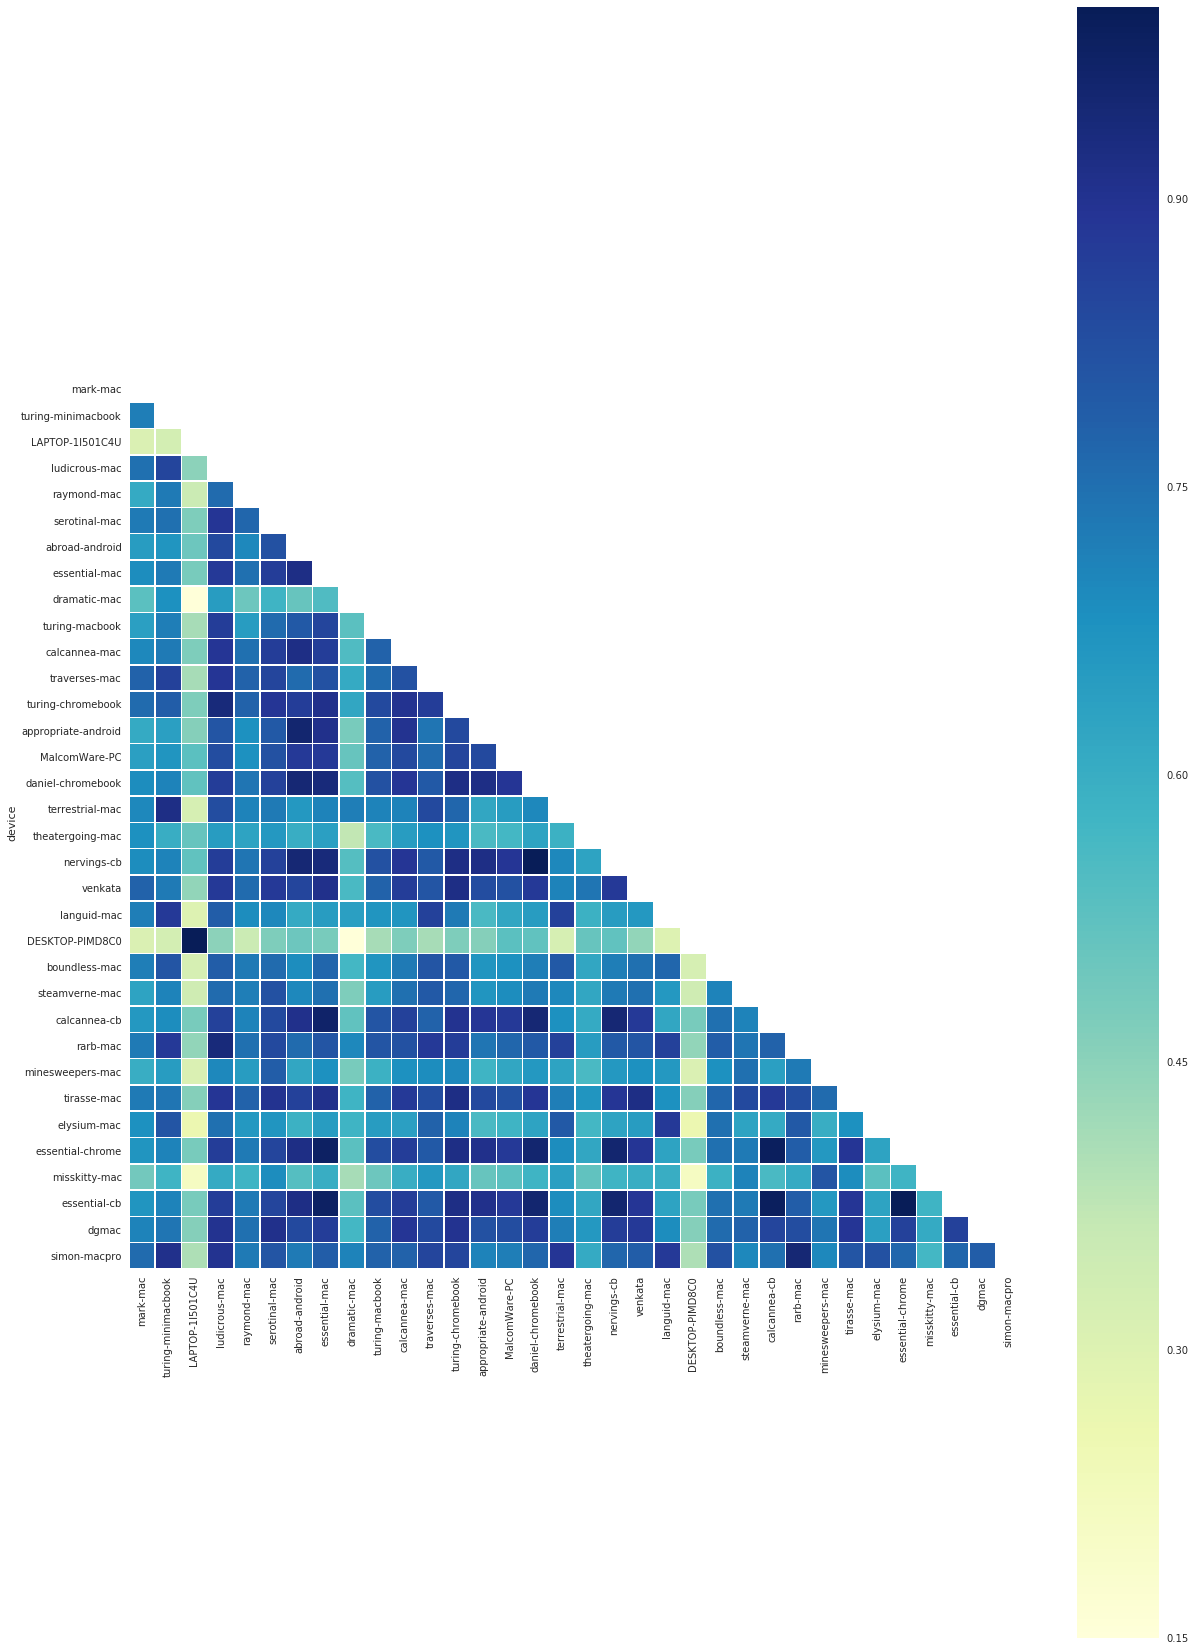

In [17]:
sns.set(style="white")
plt.figure(figsize=(20, 30))
sns.heatmap(df3[all_devices][all_devices], square=True, linewidths=0.5, mask=mask, cmap="YlGnBu")
plt.show()

## Alternative rank correlation

Higher weights nearer the 'top' of the rank list

In [18]:
# Sum of geometric progression
def geosum(a1, r, n):
    return a1 * (1 - r ** n) / (1 - r)

In [19]:
geosum(1, 3, 4)

40.0

In [20]:
# Calculate Rho on 2 lists
def correlator(a, b):
    
    coeff = 1
    ratio = 0.9
    n = max(len(a), len(b))
    bmap = {b[i]: i for i in range(0, len(b)) }

    tot = 0
    for i in range(0, len(a)):
        if a[i] in bmap:
            val = bmap[a[i]] - i
        else:
            val = n
        val = val * val * coeff * (ratio ** i)
        
        tot += val
                
    for i in range(len(a), len(b)):
        tot += len(b) * len(b)
        
    x = 1.0 - ( (6 * tot) / ( n * (n * n - 1) ) )
    s = geosum(coeff, ratio, n)
    x /= s
    return x

In [21]:
print(correlator("abcde", "edcba"))
print(correlator("abcde", "abcde"))
print(correlator("abcde", "abced"))
print(correlator("abcdefghijklmnop", "abcdefghijklmnop"))
print(correlator("abcdefgh", "poiqqwe"))

-0.15889233474152042
0.24419428096993967
0.22728260604136646
0.12274487272346256
-0.5040367544906749


In [22]:
df2 = pd.DataFrame(fav_uas, columns=["device", "useragents"]).set_index("device")
df2["coefficient"] = df2["useragents"].apply(lambda x: spearman(x, top_uas)).round(2)
df2.sort_values(by="coefficient", ascending=False)[["useragents", "coefficient"]]
everyone = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]
df3 = pd.DataFrame(fav_uas, columns=["device", "useragents"]).set_index("device")
for dev, uas in everyone:
    df3[dev] = df3["useragents"].apply(lambda x: correlator(uas, x)).round(2)
df3

,useragents,mark-mac,turing-minimacbook,LAPTOP-1I501C4U,ludicrous-mac,raymond-mac,serotinal-mac,abroad-android,essential-mac,dramatic-mac,...,calcannea-cb,rarb-mac,minesweepers-mac,tirasse-mac,elysium-mac,essential-chrome,misskitty-mac,essential-cb,dgmac,simon-macpro
device,,,,,,,,,,,,,,,,,,,,,
mark-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",0.10,0.09,0.08,0.10,0.09,0.10,0.09,0.10,0.09,...,0.10,0.10,0.09,0.10,0.09,0.10,0.09,0.10,0.10,0.10
turing-minimacbook,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",0.09,0.10,0.08,0.10,0.09,0.10,0.09,0.10,0.09,...,0.10,0.10,0.09,0.10,0.10,0.10,0.09,0.10,0.10,0.10
LAPTOP-1I501C4U,"[Microsoft-Delivery-Optimizatio, Mozilla/5.0 (...",0.08,0.08,0.10,0.09,0.08,0.09,0.09,0.09,0.09,...,0.09,0.09,0.08,0.09,0.08,0.09,0.08,0.09,0.09,0.09
ludicrous-mac,"[Mozilla/5.0 (Macintosh; Intel , server-bag [M...",0.09,0.09,0.08,0.10,0.09,0.10,0.09,0.10,0.09,...,0.10,0.10,0.09,0.10,0.09,0.10,0.09,0.10,0.10,0.10
raymond-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",0.09,0.09,0.08,0.10,0.10,0.10,0.09,0.10,0.09,...,0.10,0.10,0.09,0.10,0.09,0.10,0.09,0.10,0.10,0.09
serotinal-mac,"[Mozilla/5.0 (Macintosh; Intel , trustd (unkno...",0.09,0.09,0.08,0.10,0.09,0.10,0.09,0.10,0.09,...,0.10,0.09,0.09,0.10,0.09,0.10,0.09,0.10,0.10,0.09
abroad-android,"[Mozilla/5.0 (Linux; Android 8., Dalvik/2.1.0 ...",0.09,0.09,0.08,0.09,0.09,0.09,0.10,0.10,0.09,...,0.10,0.09,0.09,0.09,0.09,0.10,0.08,0.10,0.09,0.09
essential-mac,"[trustd (unknown version) CFNet, Python-urllib...",0.09,0.09,0.08,0.09,0.09,0.09,0.10,0.10,0.09,...,0.10,0.09,0.09,0.09,0.09,0.10,0.09,0.10,0.09,0.09
dramatic-mac,"[Roblox/Darwin, Mozilla/5.0 (Macintosh; Intel ...",0.09,0.10,0.08,0.10,0.09,0.10,0.09,0.10,0.10,...,0.09,0.10,0.09,0.09,0.10,0.10,0.09,0.10,0.10,0.10


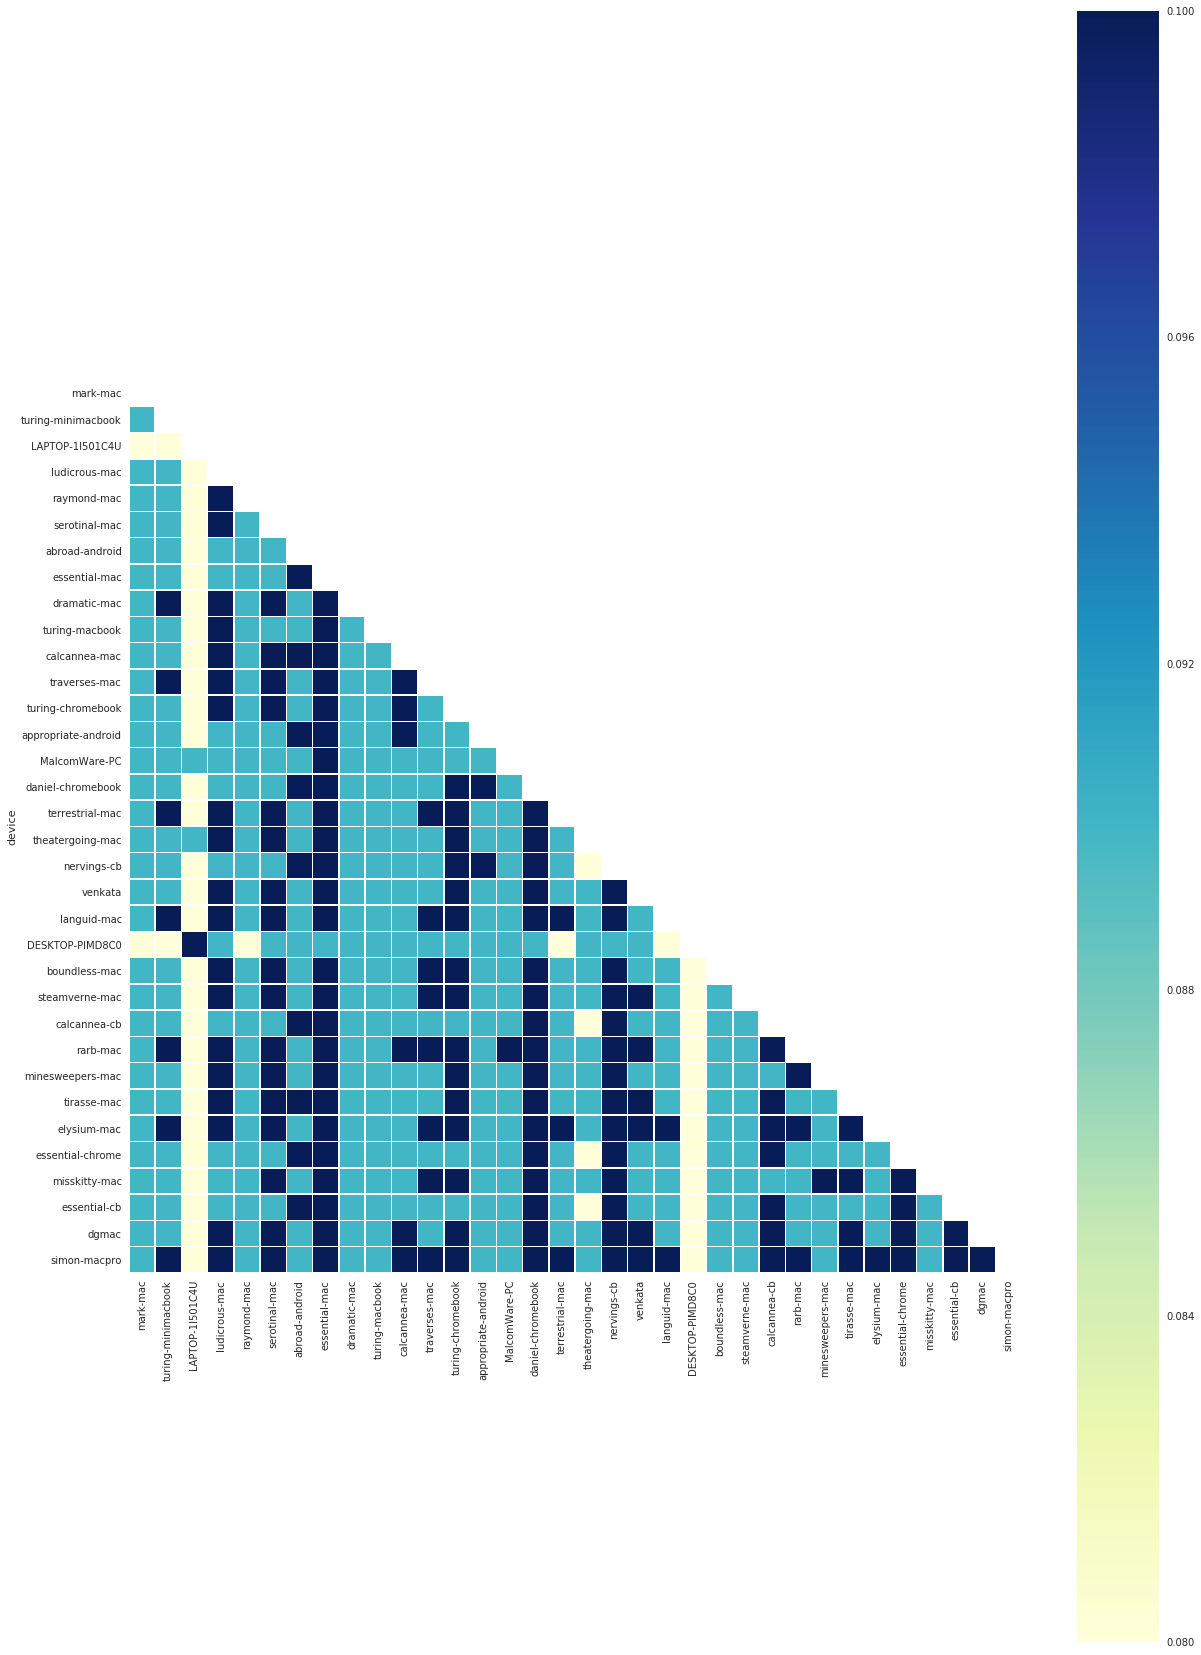

In [23]:
sns.set(style="white")
plt.figure(figsize=(20, 30))
sns.heatmap(df3[all_devices][all_devices], square=True, linewidths=0.5, mask=mask, cmap="YlGnBu")
plt.show()